<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning/blob/master/Python/chap14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第14章 半教師あり学習



## 例題 14.1

irisデータを使って自己学習を動かします。

ライブラリの読み込み

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

irisデータの読み込みと学習用・評価用の分割

In [2]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_test

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1, 2, 0, 0, 0, 1])

### 半教師ありデータの作成

まず、正解データ`y_train`の2/3がTrueとなる真偽値のインデックスを作ります。そして`y_train`を[np.copy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.copy.html)を使って変数labelsにコピーし（代入文でコピーするとオブジェクトが共有され、labelsを変更するとyも変わってしまいます）、真偽値インデックスでTrueに対応するラベルの値を「ラベルなし」を意味する「-1」に書き換えます。

In [3]:
rng = np.random.RandomState(1)
unlabeled = rng.rand(y_train.size) < 2/3
labels = np.copy(y_train)
labels[unlabeled] = -1
labels

array([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,  0, -1,  2, -1,
       -1, -1, -1,  1,  2, -1,  0,  1,  1, -1, -1, -1,  1, -1, -1,  0, -1,
        0, -1,  2,  2, -1,  0,  1,  0, -1,  1, -1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  0, -1, -1, -1, -1, -1,
        2, -1,  0, -1, -1,  1, -1, -1,  1, -1,  0,  1,  0, -1,  1, -1, -1,
        1, -1,  1, -1, -1, -1,  2, -1, -1, -1, -1,  2, -1, -1, -1])

これを教師ベクトルとして、[SelfTrainingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html)で半教師あり学習を行います。識別器には[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) （デフォルトのRBFカーネル）を識別結果に確率を付けるように、かつハイパーパラメータgammaの設定から特徴ベクトルの分散を除外するようにして使います。後者は、特徴ベクトルの分散こそが正解なしデータから得たいものだからです。

In [4]:
svc = SVC(probability=True, gamma="auto")
clf = SelfTrainingClassifier(svc, verbose=True)
clf.fit(X_train, labels)

End of iteration 1, added 50 new labels.
End of iteration 2, added 8 new labels.
End of iteration 3, added 1 new labels.


SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True),
                       verbose=True)

性能を評価します

In [5]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.95      0.97        19
           2       0.93      1.00      0.97        14

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



## 例題14.3

scikit-learnの[LabelSpreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html)でirisデータの半教師あり学習を行います。ここでは、すべてのデータを使い、正解なしデータの予測精度で評価します。

In [6]:
from sklearn.semi_supervised import LabelSpreading

unlabeled = rng.rand(y.size) < 2/3
labels = np.copy(y)
labels[unlabeled] = -1

lp = LabelSpreading(max_iter=10000)
lp.fit(X, labels)

LabelSpreading(max_iter=10000)

正解なしデータの割り当て結果を表示します。

In [7]:
lp.score(X[unlabeled], y[unlabeled])

0.9484536082474226

正解付きデータの割合を5%, 10%, 20%, 30%と変えて、それぞれ100回ずつ学習を試みて性能を評価します。

In [8]:
labeled_percent = [0.05, 0.1, 0.2, 0.3]
rng = np.random.RandomState(1)
num = y.size
for labeled in labeled_percent :
    score = 0
    for i in range(100):
        unlabeled = rng.rand(y.size) < 1-labeled
        labels = np.copy(y)
        labels[unlabeled] = -1
        lp.fit(X, labels)
        score += lp.score(X[unlabeled], y[unlabeled])
    print(f'labeled:{labeled*100:4.1f}%, score={score/100:6.3f}')

labeled: 5.0%, score= 0.812
labeled:10.0%, score= 0.925
labeled:20.0%, score= 0.939
labeled:30.0%, score= 0.944


## データ拡張

画像データ (CIFER10) の拡張を行って、性能の変化を観察します。kerasはver2.13.1を使います。

In [9]:
!pip list | grep keras

keras                            2.13.1


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [11]:
cf10 = keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


データ拡張を行う関数（Keras.Sequentialのインスタンス）を定義します。

In [12]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.07),
        keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2), fill_mode='nearest')
    ]
)

データ拡張結果を確認します。

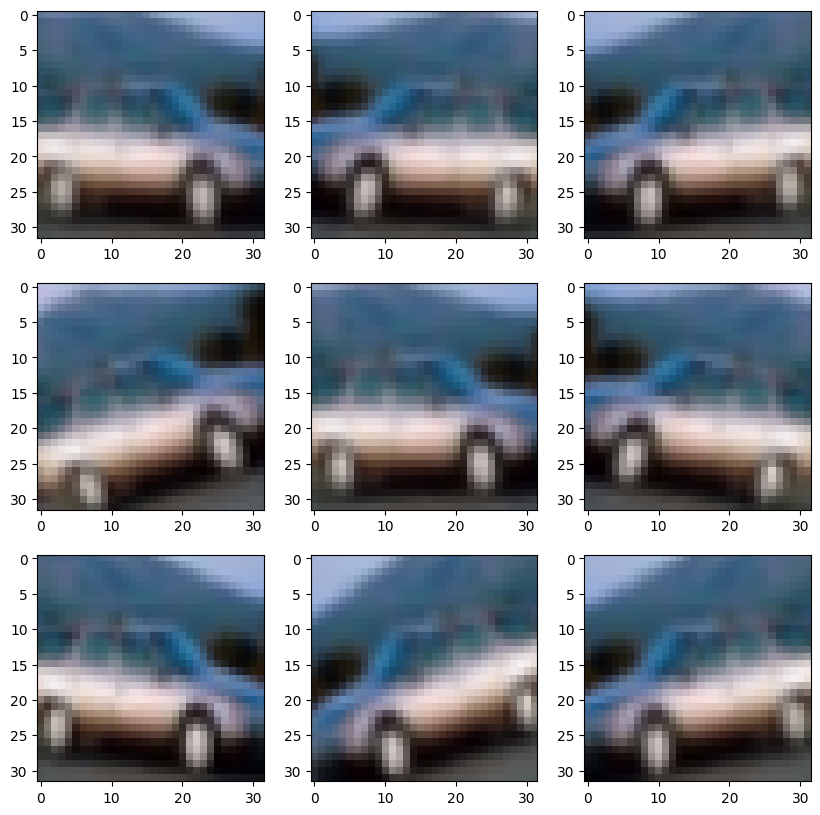

In [13]:
fig_num = 4
plt.figure(figsize=(10,10))
for i in range(9):
    im = data_augmentation(np.expand_dims(X_train[fig_num], axis=0))
    im = np.array(im).astype(int)
    plt.subplot(3, 3, i+1)
    plt.imshow(im[0])
plt.show()

In [14]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

9章の練習問題で、正解率63.5%のモデルに対してデータ拡張を行います。入力データが変動しているので、ドロップアウトは除外しておきます。

In [15]:
model3 = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model3.build(input_shape=(None, 32, 32, 3))
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 6, 6, 32)         

In [16]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

損失(loss)の減り具合などを見ながら、繰り返し回数(epochs)を調整します。

In [17]:
model3.fit(X_train, y_train, epochs=15, batch_size=128)

Epoch 1/15
391/391 [==============================] - 17s 7ms/step - loss: 1.5357 - accuracy: 0.4538
Epoch 2/15
391/391 [==============================] - 2s 6ms/step - loss: 1.2798 - accuracy: 0.5461
Epoch 3/15
391/391 [==============================] - 2s 6ms/step - loss: 1.1794 - accuracy: 0.5882
Epoch 4/15
391/391 [==============================] - 3s 7ms/step - loss: 1.1146 - accuracy: 0.6092
Epoch 5/15
391/391 [==============================] - 3s 7ms/step - loss: 1.0674 - accuracy: 0.6232
Epoch 6/15
391/391 [==============================] - 2s 6ms/step - loss: 1.0277 - accuracy: 0.6393
Epoch 7/15
391/391 [==============================] - 2s 6ms/step - loss: 0.9891 - accuracy: 0.6553
Epoch 8/15
391/391 [==============================] - 2s 6ms/step - loss: 0.9699 - accuracy: 0.6608
Epoch 9/15
391/391 [==============================] - 3s 7ms/step - loss: 0.9452 - accuracy: 0.6696
Epoch 10/15
391/391 [==============================] - 3s 7ms/step - loss: 0.9289 - accuracy: 0.675

In [18]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.6163 - accuracy: 0.5634
Test accuracy: 0.5633999705314636


## 練習問題

1. 例題14.3の手順で、使用するデータをbreast_cancerに変更して半教師あり学習を行ってください。その際、以下の点に注意してください。

* 学習時にエラーが出てしまう場合は、irisデータとbreast_cancerデータの両方のデータを見て、何が違うかを考えてみてください。
* 低い性能しか出ないときは、LabelPropagationのハイパーパラメータ調整を試みてください。

2. CNNを用いたCIFER10の識別において、データ拡張のパラメータや方法を変更して性能評価をしてください。

### 解答例


#### 練習問題1


ライブラリの読み込み

In [19]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import normalize

In [20]:
bc = load_breast_cancer()
X = bc.data
y = bc.target
print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

breast_cancerデータは各次元の値の範囲が大きく異なるので、データの距離に基づくアルゴリズムを使う場合は標準化が必要です。

In [21]:
X = normalize(X)
unlabeled_points = np.random.choice(np.arange(y.size), int((y.size)*.7), replace=False)
labels = np.copy(y)
labels[unlabeled_points] = -1

In [22]:
lp = LabelPropagation()
lp.fit(X, labels)

LabelPropagation()

In [23]:
lp.score(X[unlabeled_points], y[unlabeled_points])

0.635678391959799

すべて多数クラス(Benign: 良性)に分類したとしても$\frac{357}{212+357} \fallingdotseq 0.63$の正解率なので、学習はうまくいっていません。

RBFカーネルの範囲gammaを調整してみます。大きくするほど、近くのデータにしか影響を受けないようになります。

In [24]:
lp = LabelPropagation(gamma=2000)
lp.fit(X, labels)

LabelPropagation(gamma=2000)

In [25]:
lp.score(X[unlabeled_points], y[unlabeled_points])

0.8969849246231156

よい結果が出ているようなので、複数回実行して正解付きデータの割合と性能の関係を調べます。

In [26]:
labeled_percent = [0.05, 0.1, 0.2, 0.3, 0.5]
num = y.size
for labeled in labeled_percent :
    score = 0
    for i in range(100):
        unlabeled_points = np.random.choice(np.arange(num),int(num-num*labeled), replace=False)
        labels = np.copy(y)
        labels[unlabeled_points] = -1
        lp.fit(X, labels)
        score += lp.score(X[unlabeled_points], y[unlabeled_points])
    print(f'labeled:{labeled*100:4.1f}%, score={score/100:6.3f}')

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


labeled: 5.0%, score= 0.858
labeled:10.0%, score= 0.889
labeled:20.0%, score= 0.906
labeled:30.0%, score= 0.908
labeled:50.0%, score= 0.915


breast_cancerデータでは、LabelPropagationのハイパーパラメータをうまく調整すると、10%程度の正解付きデータである程度の性能を達成することができそうです。

#### 練習問題2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [28]:
cf10 = keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=keras.datasets.cifar10.load_data()

In [29]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.02),
        keras.layers.RandomZoom(0.05),
    ]
)

In [30]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [31]:
model3 = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model3.build(input_shape=(None, 32, 32, 3))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 6, 6, 32)         

In [32]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
391/391 [==============================] - 5s 7ms/step - loss: 1.4603 - accuracy: 0.4791
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 1.1610 - accuracy: 0.5878
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.0497 - accuracy: 0.6313
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 0.9708 - accuracy: 0.6594
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.9193 - accuracy: 0.6770
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 0.8758 - accuracy: 0.6922
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8479 - accuracy: 0.7046
Epoch 8/10
391/391 [==============================] - 3s 7ms/step - loss: 0.8153 - accuracy: 0.7143
Epoch 9/10
391/391 [==============================] - 3s 7ms/step - loss: 0.7840 - accuracy: 0.7245
Epoch 10/10
391/391 [==============================] - 3s 7ms/step - loss: 0.7629 - accuracy: 0.7316

In [33]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.9554 - accuracy: 0.6822
Test accuracy: 0.682200014591217


データ拡張において極端な変形を行うと性能が下がります。データ拡張は対象データの性質をよく検討し、慎重に行う必要があります。